In [34]:
import io
from copy import copy
from collections import OrderedDict
#from hamcrest import none
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import h5py
import mne
#import hypyp
import requests
import os
import PyQt5
import sys
import pickle
#print(sys.path)
sys.path.append('C:/Users/Administrateur/MilitaryCoordination/')

#from hypyp import (
#    prep,)  # need pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
#from hypyp import analyses
#from hypyp import prep
#from hypyp import stats
#from hypyp import viz
import autoreject

import copy
import my_utils
from my_utils import extract_trials, create_sub_epochs, AR_local_custom, ICA_autocorrect, AR_global_custom


path = r"C:\Users\nicoucke\OneDrive - UGent\Desktop\Hyperscanning 1"
raw_path = r"C:\Users\nicoucke\OneDrive - UGent\Desktop\Hyperscanning 1\raw data"
prep_path = os.path.join(path, "preprocessed data")
log_path = os.path.join(path, "logs")




## Load in data and set channels

In [68]:
name = 'P7P8_16_02.bdf'
file_path = os.path.join(raw_path, name)
log_folder_path = os.path.join(log_path, name)
if not os.path.isdir(log_folder_path):
    os.makedirs(log_folder_path)

split_name = name.split("P")
pair = int ((int(split_name[1]) + 1) / 2)


#if (pair == 33) or (pair == 28) or (pair == 15) or (pair == 12):
#   continue

print('beyond')
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_1 = raw.info.ch_names[:64]
raw_1 = raw.pick_channels(channels_1)
del raw
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_2 = raw.info.ch_names[76:140]
raw_2 = raw.pick_channels(channels_2)
del raw

            # get the montage that we will use
biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
#biosemi64_montage.plot()  # 2D

# change the channel names in our epochs so that they are the same as the montage
channels = biosemi64_montage.ch_names
mapping_1 = {}
mapping_2 = {}
for i in range(len(channels)):
    mapping_1[raw_1.info['chs'][i]['ch_name']] = str(channels[i])
    mapping_2[raw_2.info['chs'][i]['ch_name']] = str(channels[i])
mne.rename_channels(raw_1.info, mapping_1)
mne.rename_channels(raw_2.info, mapping_2)

raw_1.pick_channels(channels)
raw_2.pick_channels(channels)


# set the montage to the epochs
raw_1.set_montage(biosemi64_montage)
raw_2.set_montage(biosemi64_montage)

raw = mne.io.read_raw_bdf(file_path)


beyond
Extracting EDF parameters from C:\Users\nicoucke\OneDrive - UGent\Desktop\Hyperscanning 1\raw data\P7P8_16_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6492159  =      0.000 ...  3170.000 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\nicoucke\OneDrive - UGent\Desktop\Hyperscanning 1\raw data\P7P8_16_02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6492159  =      0.000 ...  3170.000 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from C:\Users\nicoucke\OneDrive - UGent\Desktop\Hyperscanning 1\raw data\P7P8_16_02.bdf...
BDF file detected
Setting channel info s

## Filter full-length data

In [ ]:
 #notch and band pass filtering
raw_1.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
raw_1.filter(1, 45, verbose = False)

#fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
raw_2.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
raw_2.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)



## Keep only successful trials and link to behavioral data

In [70]:
raw_events = mne.find_events(raw, shortest_event = 0)
trials = extract_trials(raw_events)
sfreq = raw.info['sfreq']
events, event_successes = create_sub_epochs(trials, sfreq)
#mne.viz.plot_events(events, sfreq=raw.info['sfreq']);
print("fs" + str(raw.info['sfreq']))
event_id = {'Synchronous/Egalitarian': 2, 'Synchronous/LeaderFollower': 3, 'Synchronous/FollowerLeader': 4, 'Individual': 5, 'Complementary/Egalitarian': 6, 'Complementary/LeaderFollower': 7, 'Complementary/FollowerLeader': 8}


with open(r"C:\Users\nicoucke\OneDrive - UGent\Desktop\Hyperscanning 1\behavioral data\Behavioral_Dataframe.pickle", "rb") as input_file:
    data_dictionary = pickle.load(input_file)

def link_eeg_to_behavioral_trials(trials, data_dictionary, pair):
    """
    only looks at successful trials
    for each trial in the behavioral data, looks if there is a corresponding eeg trial and labels it with the corresponding trialnumber
    eeg trials that did not find a match are labeled as nan
    the 'labels' are stored in the fourth column of the updated_trials matrix
    together with the condition number, these labels can then be used to link behavioral and eeg
    """


    successes = np.array(trials[:,4], dtype = int)
    segments = trials[successes == 1,:]
    #segments = segments[:,:2]
    #new_trial = [trial_begin, trial_end, trial_counter, condition, success]
    updated_trials = segments
    updated_trials[:,4] = np.nan
    #updated_trial = [trial_begin, trial_end, trial_counter, condition, trial_number]

    event_id = {'Synchronous/Egalitarian': 2, 'Synchronous/LeaderFollower': 3, 'Synchronous/FollowerLeader': 4, 'Individual': 5, 'Complementary/Egalitarian': 6, 'Complementary/LeaderFollower': 7, 'Complementary/FollowerLeader': 8}

    # get all data of the pair and then loop through the conditions
    for key, value in event_id.items():
        print(key)
        condition_sements = segments[segments[:,3] == value]
        if value in [2, 3, 4, 5]:
            sync = True
        else:
            sync = False
        
        if value in [3, 4, 7, 8]:
            hierarchy = True    
        else:
            hierarchy = False

        if value == 5:
            interactive = False
        else:
            interactive = True

        if value in [3, 7]:
            who_leader = 1
        elif value in [4, 8]:
            who_leader = 2
        else:
            who_leader = 0

            # Filter rows based on conditions
        filtered_data = data_dictionary[(data_dictionary['pair'] == pair) &
                                        (data_dictionary['sync'] == sync) & 
                                        (data_dictionary['hierarchy'] == hierarchy) & 
                                        (data_dictionary['who_leader'] == who_leader) & 
                                        (data_dictionary['interactive'] == interactive)]
        
        eeg_index = 0
        fail_counter = 0
        eeg_indices_for_trials = np.zeros((20,))
        for trial in range(1, 21):
            if np.size(condition_sements, 0) == eeg_index:
                break  

            # Iterate through each trial number
            for index, row in filtered_data.iterrows():
                # Check if the trial number matches the current trial in the loop
                if int(row['trial']) == trial:
                    # If a matching trial is found, print its completion time
                    completion_time = np.min([len(row['phase2'])/100, len(row['phase1'])/100])
                
                    eeg_time = (condition_sements[eeg_index,1] - condition_sements[eeg_index,0])/sfreq
            

                    if value == 5:
                        eeg_indices_for_trials[trial-1] = eeg_index
                        #print(f" trial {trial} | behavioral: {completion_time} | EEG: {eeg_time}")
                        continue

                    if np.abs(eeg_time - completion_time) < 0.1:
                        
                        if eeg_index not in eeg_indices_for_trials:
                            fail_counter = 0
                            eeg_indices_for_trials[trial-1] = eeg_index
                            #print(f" trial {trial} | behavioral: {completion_time} | EEG: {eeg_time}")
                        else:
                            eeg_indices_for_trials[trial-1] = np.nan
                            #print(f" trial {trial} | behavioral: {completion_time} | EEG: {0}")
                    else:
                        # case when there is one eeg too many
                        
                        next_eeg_index = eeg_index+1
                        if np.size(condition_sements, 0) == next_eeg_index:
                            eeg_indices_for_trials[trial-1] = np.nan
                            #print(f" trial {trial} | behavioral: {completion_time} | EEG: {0}")
                            break
                        next_eeg_time = (condition_sements[next_eeg_index,1] - condition_sements[next_eeg_index,0])/sfreq
                        if np.abs(next_eeg_time - completion_time) < 0.1:
                            eeg_indices_for_trials[trial-1] = next_eeg_index
                            #print(f" trial {trial} | behavioral: {completion_time} | EEG: {next_eeg_time}")
                        else:
                            # case where there is no eeg for the behavioral data
                            # go to next trial but keep current eeg index
                            eeg_indices_for_trials[trial-1] = np.nan
                            #print(f" trial {trial} | behavioral: {completion_time} | EEG: {0}")
                            fail_counter+= 1
                            if fail_counter < 2:
                                eeg_index-=1                  

                    
            eeg_index+=1
        #print(eeg_indices_for_trials)
        # now we have the indices and we use them to find the trialcounter values that we wanted
        # and then next to the trialcounter values in the original trials object we put the trialnumber values
    
        for i in range(1, 21):
            eeg_index = eeg_indices_for_trials[i-1]
            if not np.isnan(eeg_index):
                trialcounter = condition_sements[int(eeg_index),2]
                #print(trialcounter)
                updated_trials[np.where(updated_trials[:,2] == trialcounter)[0],4] = i
    return updated_trials


updated_trials = link_eeg_to_behavioral_trials(trials, data_dictionary, pair)

# only keep trials for which we found behavioral data
updated_trials = updated_trials[np.where(~np.isnan(updated_trials[:,4]))[0],:]
print(np.shape(updated_trials))

# now we will try to splice out all the data that we don't need
#new_trial = [trial_begin, trial_end, trial_counter, condition, trialnumber]

segments = updated_trials[:,:2]

cropped_segments = []

raws = [raw_1, raw_2]
spliced_raws = []
for raw_i in raws:
    # Loop through each segment and crop the raw data
    for segment in segments:
        start_index, end_index = segment
        
        # Get the corresponding start and end times using the sample indices
        start_time = raw_i.times[int(start_index-2)]
        end_time = raw_i.times[int(end_index+2)]

        # Crop the raw data using the obtained times
        cropped_segment = raw_i.copy().crop(tmin=start_time, tmax=end_time)
        cropped_segments.append(cropped_segment)

    # Concatenate the cropped segments back together
    spliced_raw = mne.concatenate_raws(cropped_segments)
    spliced_raws.append(spliced_raw)


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2947 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8   100   101   110   111
   112   113   114   115   142   143   144   145   146   147   148   150
   200   201   210   211   212   213   214   215   242   243   244   245
   246   247   248   250   253   255 65536]
[    1 65536     7 ...   214   150   250]
fs2048.0
Synchronous/Egalitarian
 trial 1 | behavioral: 4.36 | EEG: 0
 trial 2 | behavioral: 3.8 | EEG: 3.8037109375
 trial 3 | behavioral: 5.13 | EEG: 5.115234375
 trial 4 | behavioral: 4.75 | EEG: 4.74951171875
 trial 5 | behavioral: 3.79 | EEG: 3.7822265625
 trial 6 | behavioral: 4.57 | EEG: 4.5654296875
 trial 7 | behavioral: 4.59 | EEG: 4.5849609375
 trial 8 | behavioral: 4.97 | EEG: 4.96630859375
 trial 9 | behavioral: 4.03 | EEG: 4.03369140625
 tria

## Perform ICA
1) match the eye lims and 

## Reject artefacts
1) remove channels that have too high power over the whole trial and interpolate 

2) then rereference

3) then cut epochs of the trials and perform autoreject (match with controls)
a) in here, make sure that the autoreject is matched across the two participants
b) and also to the behavioral data
ccc) two-second epochs with 0.5s overlap (lon enough for envelop to make sense)
4) then check to make sure that the data are clean 
5) 

in the end we should end up with an epochs object that is matched across participants
and we should have a complementary behavioral data object in which the same behavioral epochs are extracted
filtering should be done afterwards (look to novembre paper)

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2947 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8   100   101   110   111
   112   113   114   115   142   143   144   145   146   147   148   150
   200   201   210   211   212   213   214   215   242   243   244   245
   246   247   248   250   253   255 65536]
Number of events of type 1: 1
Number of events of type 2: 27
Number of events of type 3: 40
Number of events of type 4: 28
Number of events of type 5: 28
Number of events of type 6: 26
Number of events of type 7: 48
Number of events of type 8: 33
Number of events of type 100: 90
Number of events of type 101: 85
Number of events of type 110: 158
Number of events of type 111: 140
Number of events of type 112: 134
Number of events of type 113: 108
Number of events of type 114: 127
Number of events of

In [64]:
# ok so now we should load the behavioral dataframe and only keep trials that are matched


Synchronous/Egalitarian
 trial 1 | behavioral: 4.36 | EEG: 0
 trial 2 | behavioral: 3.8 | EEG: 3.8037109375
 trial 3 | behavioral: 5.13 | EEG: 5.115234375
 trial 4 | behavioral: 4.75 | EEG: 4.74951171875
 trial 5 | behavioral: 3.79 | EEG: 3.7822265625
 trial 6 | behavioral: 4.57 | EEG: 4.5654296875
 trial 7 | behavioral: 4.59 | EEG: 4.5849609375
 trial 8 | behavioral: 4.97 | EEG: 4.96630859375
 trial 9 | behavioral: 4.03 | EEG: 4.03369140625
 trial 10 | behavioral: 4.79 | EEG: 4.78173828125
 trial 11 | behavioral: 3.82 | EEG: 3.81591796875
 trial 12 | behavioral: 4.49 | EEG: 4.48291015625
 trial 13 | behavioral: 4.61 | EEG: 4.59814453125
 trial 14 | behavioral: 4.84 | EEG: 4.83056640625
 trial 15 | behavioral: 4.09 | EEG: 4.0810546875
 trial 16 | behavioral: 4.74 | EEG: 4.73046875
 trial 17 | behavioral: 4.88 | EEG: 4.86474609375
 trial 18 | behavioral: 4.19 | EEG: 4.1806640625
 trial 19 | behavioral: 3.87 | EEG: 3.86669921875
 trial 20 | behavioral: 5.65 | EEG: 0
[nan  1.  2.  3.  4. 

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 1.000 (s)


C:\Users\nicoucke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 1.000 (s)
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
4202 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4202 events and 2049 original time points ...


C:\Users\nicoucke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
4202 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4202 events and 2049 original time points ...
0 bad epochs dropped


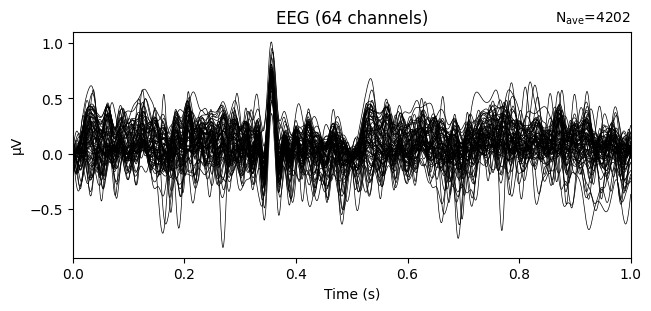

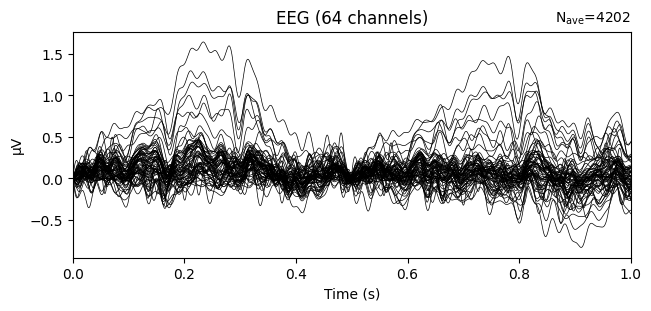

In [ ]:

# notch and band pass filtering
raw_1.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
raw_1.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'after_filtering_1_spectrum'))
#fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
raw_2.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
raw_2.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'after_filtering_2_spectrum'))
plt.close('all')

# now create the epochs a first time to get the dimensions and also to make a butterfly plot
epochs_1 = mne.Epochs(raw_1, events, event_id, event_repeated = 'drop', on_missing = 'ignore', tmin=0, tmax=1, preload=True, baseline=(0, 0))
epochs_2 = mne.Epochs(raw_2, events, event_id, event_repeated = 'drop', on_missing = 'ignore', tmin=0, tmax=1, preload=True, baseline=(0, 0))

# make now a plot of the epochs before channel rejection, rereferencing and resmapling
evoked_1 = epochs_1.average()
fig = mne.viz.plot_evoked(evoked_1, show = False)
plt.savefig(os.path.join(log_folder_path, 'post_filtering_1_epochs'))
evoked_2 = epochs_2.average()
fig = mne.viz.plot_evoked(evoked_2, show = False)
plt.savefig(os.path.join(log_folder_path, 'post_filtering_2_epochs'))

Using matplotlib as 2D backend.


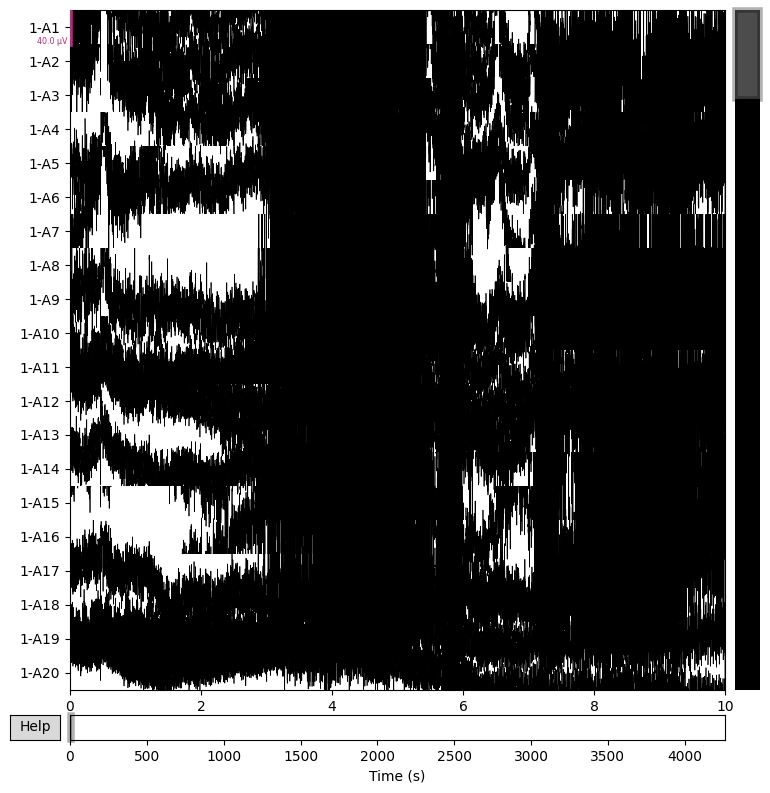

C:\Users\nicoucke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [11]:
fig = raw.plot()
fig.fake_keypress("a")

In [ ]:
log_path = os.path.join(path, "logs")
log_folder_path = os.path.join(log_path, name)


fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'raw_1_spectrum'))

raw_1.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'notch_1_spectrum'))

raw_1.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'bandpass_1_spectrum'))

raw_1.set_eeg_reference(ref_channels='average', verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'reref_1_spectrum'))

# pass the events in the function os they are also resampled
raw1, events = raw_1.resample(sfreq = 512, verbose = False, events = events)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'resamp_1_spectrum'))


fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'raw_2_spectrum'))

raw_2.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'notch_2_spectrum'))

raw_2.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'bandpass_2_spectrum'))

raw_2.set_eeg_reference(ref_channels='average', verbose = False)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'reref_2_spectrum'))

# for the second participant, pass the succes event variable for convenience
raw2, event_successes = raw_2.resample(sfreq = 512, verbose = False, events = event_successes)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'resamp_2_spectrum'))

plt.close('all')

epochs_1 = mne.Epochs(raw_1, events, event_id, event_repeated = 'drop', on_missing = 'ignore', tmin=0, tmax=1, preload=True, baseline=(0, 0))
epochs_2 = mne.Epochs(raw_2, events, event_id, event_repeated = 'drop', on_missing = 'ignore', tmin=0, tmax=1, preload=True, baseline=(0, 0))

fig = mne.Epochs.plot(epochs_1, block = False)
plt.savefig(os.path.join(log_folder_path, 'pre_ica_1_epochs'))
fig = mne.Epochs.plot(epochs_2, block = False)
plt.savefig(os.path.join(log_folder_path, 'pre_ica_2_epochs'))

icas = prep.ICA_fit([epochs_1, epochs_2],
        n_components=32,
        method='infomax',
        fit_params=dict(extended=True),
        random_state= 42)

cleaned_epochs_ICA = [epochs_1, epochs_2]
#cleaned_epochs_ICA = prep.ICA_choice_comp(icas, cleaned_epochs_ICA)
cleaned_epochs_ICA, n_ICA_excluded = ICA_autocorrect(icas, [epochs_1, epochs_2], verbose=True)

fig = mne.Epochs.plot(cleaned_epochs_ICA[0])
plt.savefig(os.path.join(log_folder_path, 'post_ica_1_epochs'))

fig = mne.Epochs.plot(cleaned_epochs_ICA[1])
plt.savefig(os.path.join(log_folder_path, 'post_ica_2_epochs'))

plt.close('all')

In [ ]:
cleaned_epochs_AR, dic_AR, bad_epochs_AR = AR_global_custom(cleaned_epochs_ICA, strategy = 'union', threshold = 50.0, verbose = False)


In [ ]:
print('apply extra segment rejection step')
bad_labels = []
rejection_ratios = []
for cleaned_epochs in cleaned_epochs_AR:
    data = cleaned_epochs.get_data()

    # create label matrix
    n_epochs = np.size(data, 0)
    n_channels = np.size(data, 1)
    label_array = np.zeros((n_epochs, n_channels))

    # for the whole data, compute the frequency spectrum and delete channels that have more than 2 SD of power than the other channels on average
    # later try also with fixed threshold
    
    psds, freqs = mne.time_frequency.psd_welch(cleaned_epochs, fmin = 0, fmax = 50)

    channel_powers = []
    for channel_index in range(64):
        psd_channel = psds[channel_index, :]
        average_power = psd_channel.mean()
        channel_powers.append(average_power)
    
    print(channel_powers)

    
    threshold = 100 # microvolt

    standard_dev = np.std(data, axis = 2)
    mean_std = np.mean(standard_dev)
    std_std = np.std(standard_dev)
    std_threshold = mean_std + 3*std_std

    
    for epoch in range(n_epochs):
        for channel in range(n_channels):
            ptp = np.max(data[epoch, channel,:]) - np.min(data[epoch, channel,:])
            std = np.std(data[epoch, channel,:])
            if ptp > threshold*1e-06:
                label_array[epoch, channel] = 1
            if std > std_threshold:
                label_array[epoch, channel] = 1
                
    rejection_ratio = np.sum(label_array) / np.size(label_array)
    print('proportion_rejected =' + str(rejection_ratio))
    bad_labels.append(label_array)
    rejection_ratios.append(rejection_ratio)

preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]


In [ ]:
try:
    del epochs_1, epochs_2
except:
    print('define raw')
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_1 = raw.info.ch_names[:64]
print(channels_1)
print(len(channels_1))
raw_1 = raw.pick_channels(channels_1)
del raw
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_2 = raw.info.ch_names[76:140]
raw_2 = raw.pick_channels(channels_2)
del raw
print(channels_2)
print(len(channels_2))


In [ ]:


# get the montage that we will use
biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
biosemi64_montage.plot()  # 2D

# change the channel names in our epochs so that they are the same as the montage
channels = biosemi64_montage.ch_names
mapping_1 = {}
mapping_2 = {}
for i in range(len(channels)):
    mapping_1[raw_1.info['chs'][i]['ch_name']] = str(channels[i])
    mapping_2[raw_2.info['chs'][i]['ch_name']] = str(channels[i])
mne.rename_channels(raw_1.info, mapping_1)
mne.rename_channels(raw_2.info, mapping_2)

raw_1.pick_channels(channels)
raw_2.pick_channels(channels)


# set the montage to the epochs
raw_1.set_montage(biosemi64_montage)
raw_2.set_montage(biosemi64_montage)

In [7]:
name = 'P1P2_15_02.bdf'
file_path = os.path.join(raw_path, name)
log_folder_path = os.path.join(log_path, name)
if not os.path.isdir(log_folder_path):
    os.makedirs(log_folder_path)

split_name = name.split("P")
pair = int ((int(split_name[1]) + 1) / 2)


#if (pair == 33) or (pair == 28) or (pair == 15) or (pair == 12):
#   continue

print('beyond')
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_1 = raw.info.ch_names[:64]
raw_1 = raw.pick_channels(channels_1)
del raw
raw = mne.io.read_raw_bdf(file_path, preload = True)
channels_2 = raw.info.ch_names[76:140]
raw_2 = raw.pick_channels(channels_2)
del raw

            # get the montage that we will use
biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
#biosemi64_montage.plot()  # 2D

# change the channel names in our epochs so that they are the same as the montage
channels = biosemi64_montage.ch_names
mapping_1 = {}
mapping_2 = {}
for i in range(len(channels)):
    mapping_1[raw_1.info['chs'][i]['ch_name']] = str(channels[i])
    mapping_2[raw_2.info['chs'][i]['ch_name']] = str(channels[i])
mne.rename_channels(raw_1.info, mapping_1)
mne.rename_channels(raw_2.info, mapping_2)

raw_1.pick_channels(channels)
raw_2.pick_channels(channels)


# set the montage to the epochs
raw_1.set_montage(biosemi64_montage)
raw_2.set_montage(biosemi64_montage)

raw = mne.io.read_raw_bdf(file_path)
raw_events = mne.find_events(raw, shortest_event = 0)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'F:/'

In [ ]:
#%matplotlib qt
# for separate plot use %matplotlib qt
#%matplotlib qt
# for inline plot use %matplotlib inline

# make sure you take into account the downsampling
from my_utils import create_time_locked_epochs
raw = mne.io.read_raw_bdf(file_path)
raw_events = mne.find_events(raw, shortest_event = 0)
trials = extract_trials(raw_events)
sfreq = raw.info['sfreq']

old_events = raw_events
# put in the raw function
event_values = old_events[:, 2]
event_samples = old_events[:,0]
events = np.empty(3,)
event_info = np.empty(3,) # (trial number, successful, baseline)
for trial_index in range(np.size(trials,0)):
    trial_start = trials[trial_index, 0]
    trial_end = trials[trial_index, 1]
    condition = trials[trial_index, 3]
    success = trials[trial_index, 4]

    # first add the baseline (start of trial)
    event = [trial_start, 0, condition]
    events = np.vstack((events, np.array(event)))
    info = [trial_index, 0, 1]
    event_info = np.vstack((event_info, info))

    # find the events happening within this trial
    trial_events = np.where((trial_start < event_samples) & (trial_end > event_samples))[0]

    

    if condition in [2, 3, 4, 5]:
        # find the first cross of the checkpoint
        crossed_points = []
        for trial_event in trial_events:
            event_value = str(event_values[trial_event])
           
            if len(event_value) < 3:
                continue
                
            player_crossed = int(event_value[0:2])
            checkpoint = int(event_value[2])
            
            if ((player_crossed == 21) or (player_crossed == 11)) and (checkpoint not in crossed_points):
                # add checkpoint to list

                event_sample = event_samples[trial_event]
                # only add the event when the last one was less than 500ms before so as to not mix them too much
                if (event_sample - events[-1, 0]) > 0.5*sfreq:
                    event = [event_sample, 0, condition]
                    events = np.vstack((events, np.array(event)))
                    info = [trial_index, 1, 0]
                    event_info = np.vstack((event_info, info))

                # of if they are game over
            elif ((player_crossed == 24) or (player_crossed == 14)):
                event_sample = event_samples[trial_event]
                event = [event_sample, 0, condition]
                events = np.vstack((events, np.array(event)))
                info = [trial_index, 0, 0]
                event_info = np.vstack((event_info, info))


    elif condition in [6,7,8]:
        # find the first cross of the desync
        crossed_points = []
        for trial_event in trial_events:
            event_value = str(event_values[trial_event])
            
            if len(event_value) < 3:
                continue
                
            player_crossed = int(event_value[0:2])
            checkpoint = int(event_value[2])

            # only for desync points
            if ((player_crossed == 20) or (player_crossed == 10)) and (checkpoint not in crossed_points):
                # add checkpoint to list
                event_sample = event_samples[trial_event]
                event = [event_sample, 0, condition]

                info = [trial_index, 1, 0]
                event_info = np.vstack((event_info, info))

            # or if they are game over
            elif ((player_crossed == 24) or (player_crossed == 14)):
                event_sample = event_samples[trial_event]
                event = [event_sample, 0, condition]

                info = [trial_index, 0, 0]
                event_info = np.vstack((event_info, info))






#events, event_successes = create_time_locked_epochs(trials, sfreq, raw_events)
np.set_printoptions(threshold=sys.maxsize)
print(events)
#mne.viz.plot_events(events, sfreq);
#print("fs" + str(sfreq))
event_id = {'Synchronous/Egalitarian': 2, 'Synchronous/LeaderFollower': 3, 'Synchronous/FollowerLeader': 4, 'Individual': 5, 'Complementary/Egalitarian': 6, 'Complementary/LeaderFollower': 7, 'Complementary/FollowerLeader': 8}





In [ ]:
%matplotlib qt
log_path = os.path.join(path, "logs")
log_folder_path = os.path.join(log_path, name)


fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'raw_1_spectrum'))

raw_1.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'notch_1_spectrum'))

raw_1.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'bandpass_1_spectrum'))

raw_1.set_eeg_reference(ref_channels='average', verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'reref_1_spectrum'))

# pass the events in the function os they are also resampled
raw1, events = raw_1.resample(sfreq = 512, verbose = False, events = events)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'resamp_1_spectrum'))


fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'raw_2_spectrum'))

raw_2.notch_filter(freqs = [50, 100, 150, 200, 250], filter_length='auto', method = 'fir', trans_bandwidth = 4, verbose = False)
fig = mne.viz.plot_raw_psd(raw_1, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'notch_2_spectrum'))

raw_2.filter(1, 45, verbose = False)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'bandpass_2_spectrum'))

raw_2.set_eeg_reference(ref_channels='average', verbose = False)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'reref_2_spectrum'))

# for the second participant, pass the succes event variable for convenience
raw2, event_successes = raw_2.resample(sfreq = 512, verbose = False, events = event_successes)
fig = mne.viz.plot_raw_psd(raw_2, area_mode='range', average=False)
plt.savefig(os.path.join(log_folder_path, 'resamp_2_spectrum'))


In [ ]:

%reset_selective -f epochs_1, epochs_2
epochs_1 = mne.Epochs(raw_1, events, event_id, event_repeated = 'drop', tmin=0, tmax=1, preload=True, baseline=(0, 0))
epochs_2 = mne.Epochs(raw_2, events, event_id, event_repeated = 'drop', tmin=0, tmax=1, preload=True, baseline=(0, 0))

fig = mne.Epochs.plot(epochs_1)
plt.savefig(os.path.join(log_folder_path, 'pre_ica_1_epochs'))
fig = mne.Epochs.plot(epochs_2)
plt.savefig(os.path.join(log_folder_path, 'pre_ica_2_epochs'))

print(epochs_1.events)

In [ ]:
# after rereferencing and filtering
# do autoreject and ica
icas = prep.ICA_fit([epochs_1, epochs_2],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state= 42)

In [ ]:
#cleaned_epochs_ICA = prep.ICA_autocorrect(icas, [epochs_1, epochs_2], verbose=True)
#cleaned_epochs_ICA = prep.ICA_choice_comp(icas, cleaned_epochs_ICA)
cleaned_epochs_ICA, n_ICA_excluded = ICA_autocorrect(icas, [epochs_1, epochs_2], verbose=True)

fig = mne.Epochs.plot(cleaned_epochs_ICA[0])
plt.savefig(os.path.join(log_folder_path, 'post_ica_2_epochs'))
fig = mne.Epochs.plot(cleaned_epochs_ICA[1])
plt.savefig(os.path.join(log_folder_path, 'post_ica_2_epochs'))


In [ ]:

n_interpolates = np.array([1, 2, 3, 4, 5, 6])
consensus_percs = np.linspace(0, 0.5, 11)

before_cleaning = copy.deepcopy(cleaned_epochs_ICA)

cleaned_epochs_AR, dic_AR, bad_epochs_AR  = AR_local_custom(cleaned_epochs_ICA, n_interpolates, consensus_percs,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=False
)


pair_info = dict()
pair_info['n_ICA_excluded'] = n_ICA_excluded
pair_info['dic_AR'] = dic_AR
pair_info['bad_epochs_AR'] = bad_epochs_AR



In [ ]:
print(cleaned_epochs_AR)
fig = mne.Epochs.plot(cleaned_epochs_AR[0])
fig.savefig(os.path.join(log_folder_path, '_after_AR_1_union'))

fig = mne.Epochs.plot(cleaned_epochs_AR[1])
fig.savefig(os.path.join(log_folder_path,  '_after_AR_2_union'))

n_ICA_excluded = pair_info['n_ICA_excluded']
dic_AR = pair_info['dic_AR']
bad_epochs_AR = pair_info['bad_epochs_AR'] 

bad_epochs_AR[0].plot()
plt.savefig(os.path.join(log_folder_path, 'AR_rejection_log_1'))
bad_epochs_AR[1].plot()
plt.savefig(os.path.join(log_folder_path, 'AR_rejection_log_2'))

print(bad_epochs_AR[0])

In [ ]:
%matplotlib qt
# for separate plot use %matplotlib qt
#%matplotlib inline
# for inline plot use %matplotlib inline

for pair in range(1):
    storePath = "F:\hyperscanning_mne\pair_10"

    file_path = os.path.join("F:/hyperscanning_mne", "pair_" + str(pair+1))

    try: 
        with open(file_path , "rb") as input_file:
            cleaned_epochs_AR, pair_info = pickle.load(input_file)
    except:
        continue

    bad_labels = []
    rejection_ratios = []
    for cleaned_epochs in cleaned_epochs_AR:
        data = cleaned_epochs.get_data()

        n_epochs = np.size(data, 0)
        n_channels = np.size(data, 1)
        threshold = 75 # microvolt

        standard_dev = np.std(data, axis = 2)
        mean_std = np.mean(standard_dev)
        std_std = np.std(standard_dev)
        std_threshold = mean_std + 3*std_std

        label_array = np.zeros((n_epochs, n_channels))
        for epoch in range(n_epochs):
            for channel in range(n_channels):
                ptp = np.max(data[epoch, channel,:]) - np.min(data[epoch, channel,:])
                std = np.std(data[epoch, channel,:])
                if ptp > threshold*1e-06:
                    label_array[epoch, channel] = 1
                if std > std_threshold:
                    label_array[epoch, channel] = 1
        rejection_ratio = np.sum(label_array) / np.size(label_array)
        print('proportion_rejected =' + str(rejection_ratio))
        bad_labels.append(label_array)
        rejection_ratios.append(rejection_ratio)

        plt.imshow(label_array)
        plt.show()
    storepath = os.path.join("F:/hyperscanning_mne", "bad_labels_pair_" + str(pair))
    with open(storepath, "wb") as output_file: 
        pickle.dump([bad_labels, rejection_ratios], output_file, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:

# or load the preprocessed data

preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

psd1 = analyses.pow(preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
psd2 = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
data_psd = np.array([psd1.psd, psd2.psd])



In [ ]:
# figure out what is wrong here with the data it seems to be empty

freq_bands = {'Theta': [4, 7],
                'Alpha': [8, 12],
                'Beta': [13, 30],
                'Gamma': [30, 45]}
freq_bands = OrderedDict(freq_bands)
# select condition and frequency band
event_id = {'Synchronous/Egalitarian': 2, 'Synchronous/LeaderFollower': 3, 'Synchronous/FollowerLeader': 4, 'Individual': 5, 'Complementary/Egalitarian': 6, 'Complementary/LeaderFollower': 7, 'Complementary/FollowerLeader': 8}
pair_complex_signal_dict = {}
for condition in event_id.keys():
    print(condition)
    print(preproc_S1[condition])
    data_inter = np.array([preproc_S1[condition], preproc_S2[condition]])
    condition_complex_signal_dict = {}
    for band in freq_bands:
        print(band)
        try:
            complex_signal = analyses.compute_freq_bands(data_inter, 512, {band: freq_bands[band]})
            print(complex_signal.shape)
            condition_complex_signal_dict[band] = complex_signal
        except:
            condition_complex_signal_dict[band] = []
    pair_complex_signal_dict[condition] = condition_complex_signal_dict

In [ ]:
pair_complex_signal_dict[condition] 
n_ch = len(preproc_S1.info['ch_names'])
connectivity_values = dict()
for condition in event_id.keys():
    condition_complex_signal_dict = pair_complex_signal_dict[condition]

    condition_connectivity_values = dict()
    for band in freq_bands:
        complex_signal = condition_complex_signal_dict[band]
        # run epoch per epoch so that not loading to much data at once
        band_results = 
        epoch_size = int(np.floor(np.size(complex_signal,1)/10))
        for epoch in range(epoch_size):
            results = analyses.compute_sync(complex_signal[:, epoch*10: 10*(epoch+1), :, :, :], mode='wpli', epochs_average = False)
            band_results = 
        #band_results = np.concatenate(results[:, 0:n_ch, n_ch:2*n_ch]    
        condition_connectivity_values[band] = band_results

    connectivity_values[condition] = condition_connectivity_values



In [ ]:
pair = 0
file_path = os.path.join("F:/hyperscanning_mne", "connectivity_values_pair_" + str(pair+1))
with open(file_path , "rb") as input_file:
        cleaned_epochs_AR, dic_AR = pickle.load(input_file)

In [ ]:
# Get the events
events = mne.find_events(raw, shortest_event = 0)

# Get unique event types
event_types = np.unique(events[:, 2])

# Create a dictionary to map each event type to a unique y-height
event_type_y_height = {event_type: idx for idx, event_type in enumerate(event_types)}

# Plot all events with each event indicated by a dot at a different y-height
plt.figure(figsize=(15, 5))
for event in events:
    event_sample = event[0]
    event_type = event[2]
    y_height = event_type_y_height[event_type]
    plt.plot(event_sample, y_height, 'o', color='black')

# Set y-axis labels
plt.yticks(range(len(event_types)), [f'Event {event_type}' for event_type in event_types])

# Set x-axis label and title
plt.xlabel('Time (samples)')
plt.title('Events in Raw Data')

plt.show()


# Get the events
events = mne.find_events(spliced_raw, shortest_event = 0)

# Get unique event types
event_types = np.unique(events[:, 2])

# Create a dictionary to map each event type to a unique y-height
event_type_y_height = {event_type: idx for idx, event_type in enumerate(event_types)}

# Plot all events with each event indicated by a dot at a different y-height
plt.figure(figsize=(15, 5))
for event in events:
    event_sample = event[0]
    event_type = event[2]
    y_height = event_type_y_height[event_type]
    plt.plot(event_sample, y_height, 'o', color='black')

# Set y-axis labels
plt.yticks(range(len(event_types)), [f'Event {event_type}' for event_type in event_types])

# Set x-axis label and title
plt.xlabel('Time (samples)')
plt.title('Events in Raw Data')

plt.show()


In [ ]:
# Get the events
events = mne.find_events(raw, shortest_event=0)

# Get unique event types and their counts
event_types, event_counts = np.unique(events[:, 2], return_counts=True)

# Print the number of events of each type
for event_type, event_count in zip(event_types, event_counts):
    print(f"Number of events of type {event_type}: {event_count}")

events = mne.find_events(spliced_raw, shortest_event=0)

# Get unique event types and their counts
event_types, event_counts = np.unique(events[:, 2], return_counts=True)

# Print the number of events of each type
for event_type, event_count in zip(event_types, event_counts):
    print(f"Number of events of type {event_type}: {event_count}")
